In [3]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.size"] = 15
%matplotlib inline
print("Version of pytorch is {}".format(torch.__version__))

Version of pytorch is 2.2.1+cu121


In [4]:
num_input = 2
num_hidden1 = 50
num_hidden2 = 50
num_output = 1

class DQN(nn.Module):
  def __init__(self, num_input,num_hidden1,num_hidden2,num_output):
    super(DQN,self).__init__()
    self.layer1 = nn.Linear(num_input,num_hidden1)
    self.layer2 = nn.Linear(num_hidden1,num_hidden2)
    self.layer3 = nn.Linear(num_hidden2, num_output)

  def forward(self,x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = torch.sigmoid(self.layer3(x))
    return x


model = DQN(num_input,num_hidden1,num_hidden2,num_output)
print(model)

DQN(
  (layer1): Linear(in_features=2, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (layer3): Linear(in_features=50, out_features=1, bias=True)
)


In [5]:
K_test = np.array([[1., 1.], [0.5, 2.]])
K_test_tensor = torch.tensor(K_test, dtype=torch.float32)

model.eval()
with torch.no_grad():
    predictions = model(K_test_tensor)

print("K_test = ", K_test)
print("nn prediction = ", predictions.numpy())

K_test =  [[1.  1. ]
 [0.5 2. ]]
nn prediction =  [[0.48401153]
 [0.50114226]]


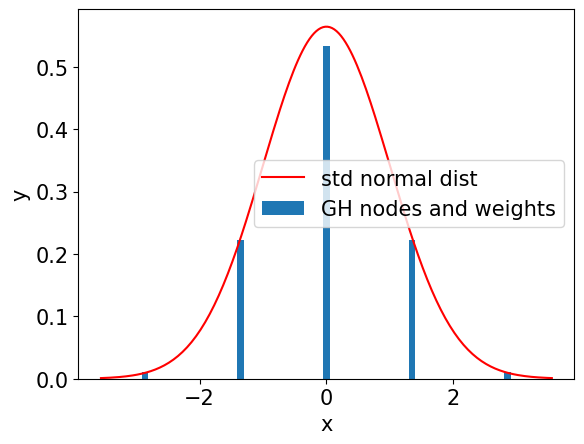

sum(w_int) =  1.0000001


In [9]:
n_int = 5
x_int_norm,w_int = np.polynomial.hermite.hermgauss(n_int)
w_int = w_int / np.sqrt(np.pi)
x_int_norm = x_int_norm * np.sqrt(2)
#convert to torch

x_int_norm = torch.tensor(x_int_norm, dtype = torch.float32)
w_int = torch.tensor(w_int, dtype = torch.float32)



In [10]:
alpha = 0.36  # Capital share in the Cobb-Douglas production function
beta = 0.99  # Discount factor
delta = 0.1 # depreciation of capital
sigma_tfp = 0.04 # std. dev. for tfp process innvoations
rho_tfp = 0.9 # persistence of tfp process
x_int = x_int_norm * sigma_tfp # adjust the integration nodes

def k_compute_infty(alpha, beta):
    """ Return the stationary point (or steady state) for full depreciation """
    return (1 / (beta * alpha))**(1/(alpha - 1))

k_infty = k_compute_infty(alpha, beta)
print("Stationary point is {:5f}".format(k_infty))


def Kplus_compute_analytic(K, alpha, beta):
    """ Return the optimal capital stock in the next period  for full depreciation """
    return alpha * beta * K**alpha


def c_compute(K, Knext, alpha, beta):
    """ Return the optimal consumption policy  for full depreciation """
    return Knext**alpha - Knext

Stationary point is 0.199482


In [17]:
def get_singleinside(X_tplus1, model):
    # read out the state
    Z_tplus1 = X_tplus1[:, 0:1]
    K_tplus1 = X_tplus1[:, 1:2]

    # compute output
    Y_tplus1 = Z_tplus1 * K_tplus1 ** alpha

    # compute the return
    r_tplus1 = alpha * Z_tplus1 * K_tplus1 ** (alpha - 1.)

    # use the neural network to predict the savings rate
    s_tplus1 = model(X_tplus1)

    # Compute consumption
    C_tplus1 = Y_tplus1 - Y_tplus1 * s_tplus1

    # compute term inside the expectation
    ret = (1. / C_tplus1) * (1. - delta + r_tplus1)

    return ret

In [18]:
X_tplus1 = torch.tensor([[1., 1.], [2., 2.], [2., 1.3]], dtype=torch.float32)

ret = get_singleinside(X_tplus1, model)
print("ret = ", ret)

ret =  tensor([[2.4419],
        [1.0624],
        [1.3133]], grad_fn=<MulBackward0>)


In [21]:
def compute_cost_tuple(X, model):
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    Z_t = X[:, 0:1]
    K_t = X[:, 1:2]

    # compute output today
    Y_t = Z_t * K_t ** alpha

    # compute return (not really needed)
    r_t = alpha * Z_t * K_t ** (alpha - 1.)

    # use the neural network to predict the savings rate
    s_t = model(X)

    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # get consumption
    C_t = Y_t - Y_t * s_t

    # now we have to compute the expectation
    expectation = torch.zeros((n_data, dim_state))

    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]

        # innovation to the AR(1)
        innovation_i = x_int[i]

        # construct exogenous shock at t+1
        Z_tplus1 = torch.exp(rho_tfp * torch.log(Z_t) + innovation_i)

        # construct state at t+1
        X_tplus1 = torch.cat([Z_tplus1, K_tplus1], dim=1)

        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, model)

        # add term to the expectaion with the appropriate weight
        expectation += weight_i * inside_i

    # now we have all terms to construct the relative Euler error

    # Define the relative Euler error
    errREE = 1. - 1. / (C_t * beta * expectation)

    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = torch.mean(errREE ** 2)

    # we return some more things for plotting
    LHS = 1. / C_t # LHS of Ee
    RHS = beta * expectation # RHS of Ee

    return cost, errREE, C_t, K_tplus1, r_t, LHS, RHS


def compute_cost(X, model):
    n_data = X.shape[0] # number of states is on the axis 0
    dim_state = X.shape[1] # dimensionality of the state is on axis 1

    # read out the state
    Z_t = X[:, 0:1]
    K_t = X[:, 1:2]

    # compute output today
    Y_t = Z_t * K_t ** alpha

    # compute return (not really needed)
    r_t = alpha * Z_t * K_t ** (alpha - 1.)

    # use the neural network to predict the savings rate
    s_t = model(X)

    # get the implied capital in the next period
    K_tplus1 = (1. - delta) * K_t + Y_t * s_t

    # get consumption
    C_t = Y_t - Y_t * s_t

    # now we have to compute the expectation
    expectation = torch.zeros((n_data, dim_state))

    # we loop over the integration nodes
    for i in range(n_int):
        # integration weight
        weight_i = w_int[i]

        # innovation to the AR(1)
        innovation_i = x_int[i]

        # construct exogenous shock at t+1
        Z_tplus1 = torch.exp(rho_tfp * torch.log(Z_t) + innovation_i)

        # construct state at t+1
        X_tplus1 = torch.cat([Z_tplus1, K_tplus1], dim=1)

        # compute term inside the expeectation
        inside_i = get_singleinside(X_tplus1, model)

        # add term to the expectaion with the appropriate weight
        expectation += weight_i * inside_i

    # now we have all terms to construct the relative Euler error

    # Define the relative Euler error
    errREE = 1. - 1. / (C_t * beta * expectation)

    # compute the cost, i.e. the mean square error in the equilibrium conditions
    cost = torch.mean(errREE ** 2)

    # we return some more things for plotting
    LHS = 1. / C_t # LHS of Ee
    RHS = beta * expectation # RHS of Ee

    return cost

In [23]:
X_test1 = torch.tensor([[1., 1.], [2., 2.], [2., 1.3]], dtype=torch.float32)
cost_test = compute_cost(X_test1, model)
print("cost = " , cost_test)

cost =  tensor(0.0174, grad_fn=<MeanBackward0>)


In [24]:
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
def get_training_data(z_lb, z_ub, k_lb, k_ub, n_data):
    Z = torch.rand(n_data, 1) * (z_ub - z_lb) + z_lb
    K = torch.rand(n_data, 1) * (k_ub - k_lb) + k_lb
    X = torch.cat([Z, K], dim=1)
    return X

#=================================================================
episode = 0, loss [log10] = -2.820381173900401


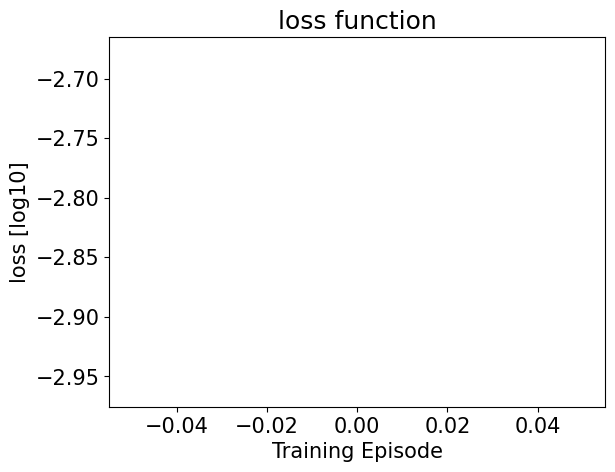

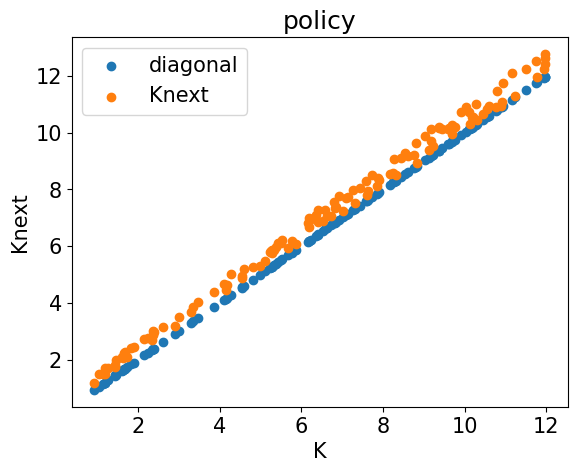

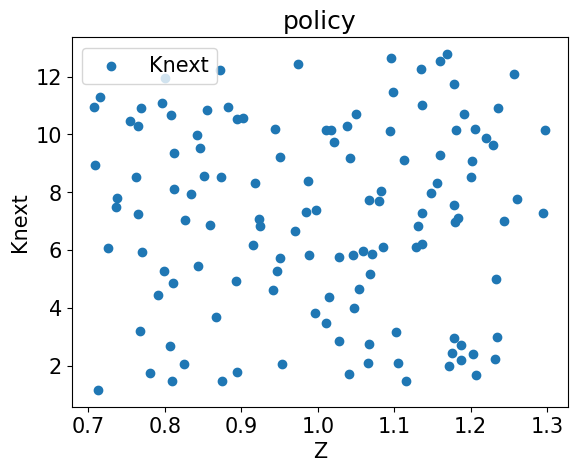

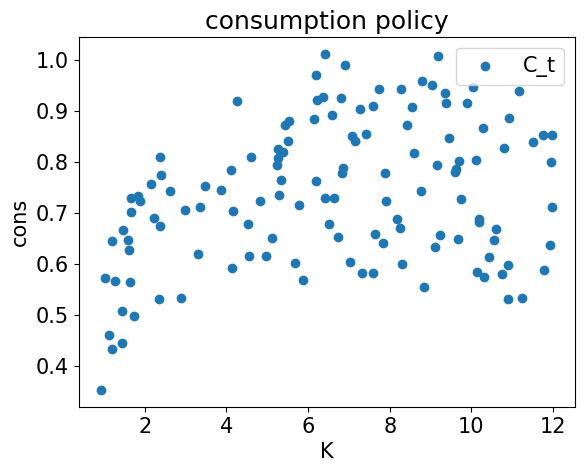

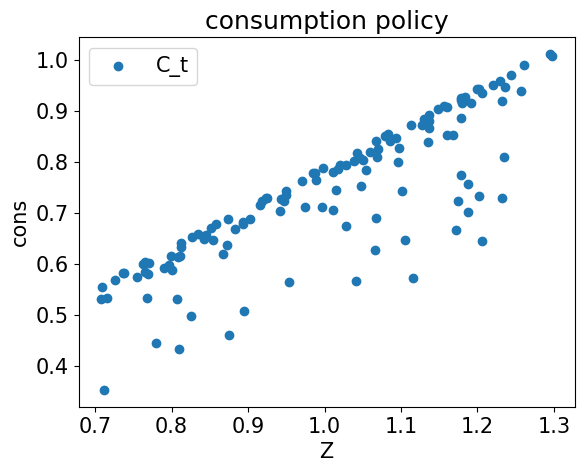

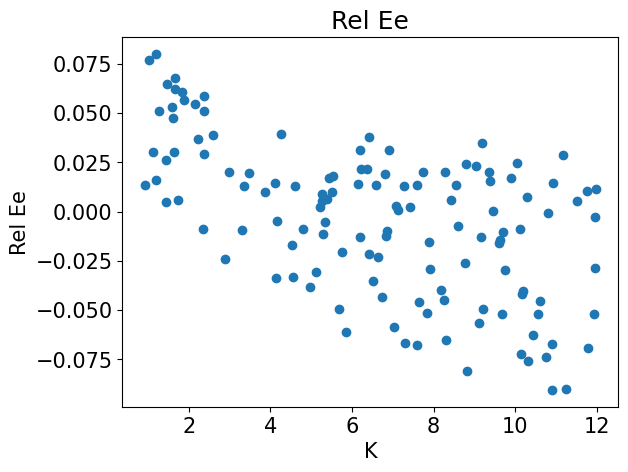

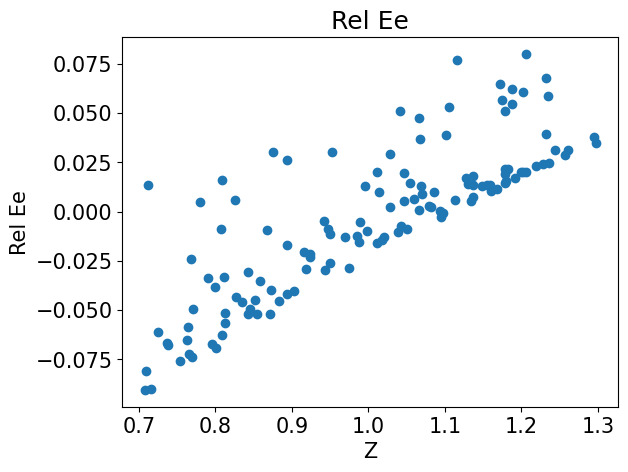

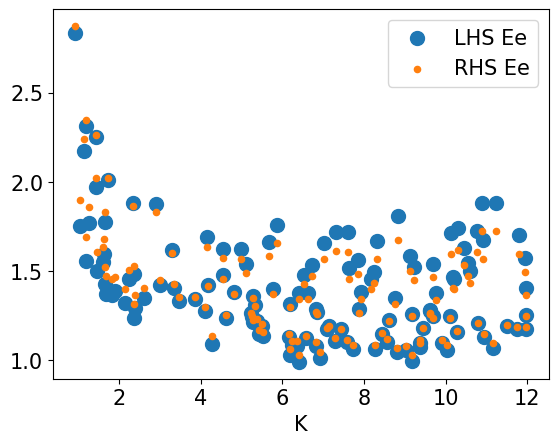

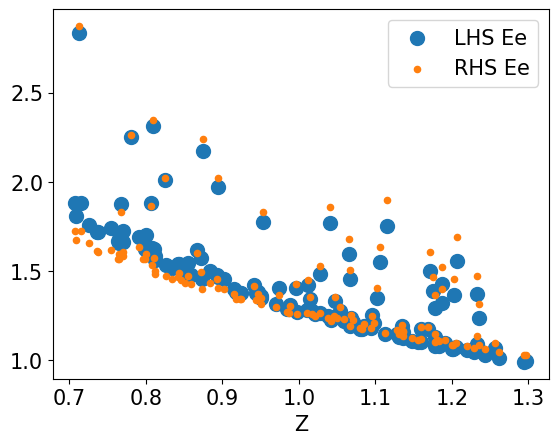

#=================================================================
episode = 1000, loss [log10] = -4.567577056691255
#=================================================================
episode = 2000, loss [log10] = -5.135494591020436
#=================================================================
episode = 3000, loss [log10] = -5.269710679316651
#=================================================================
episode = 4000, loss [log10] = -5.076072568952274


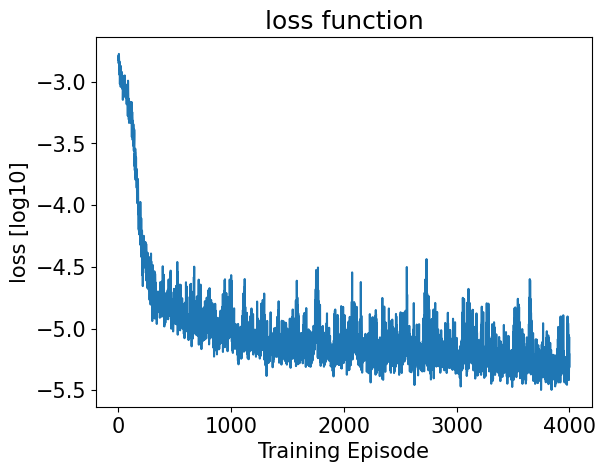

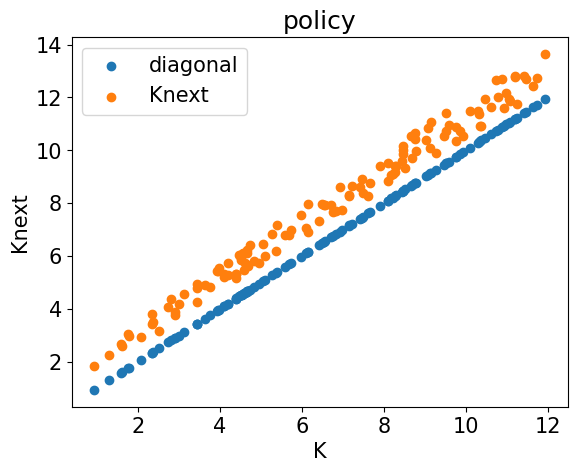

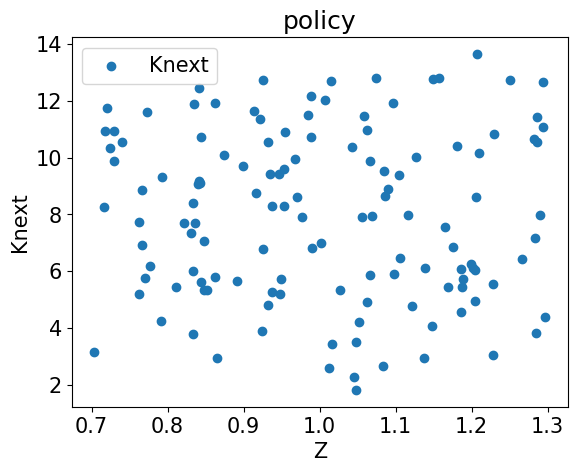

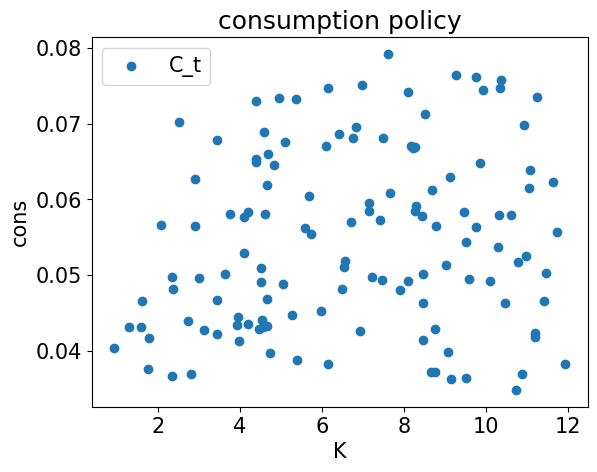

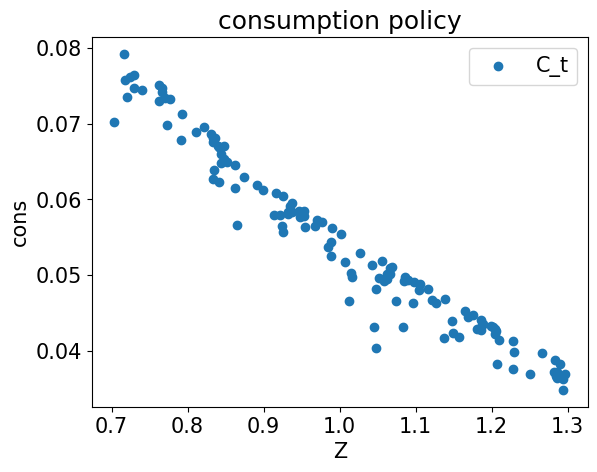

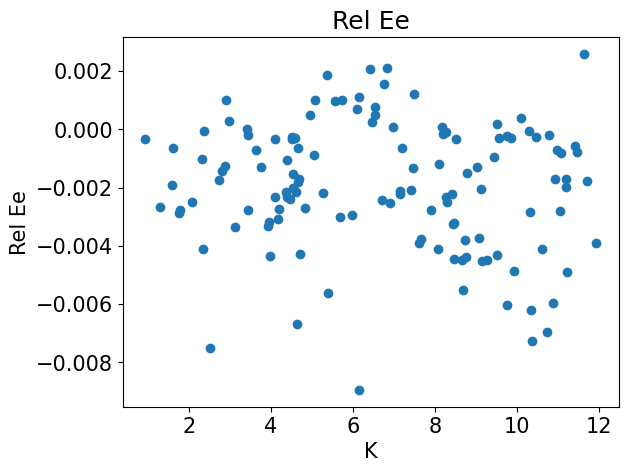

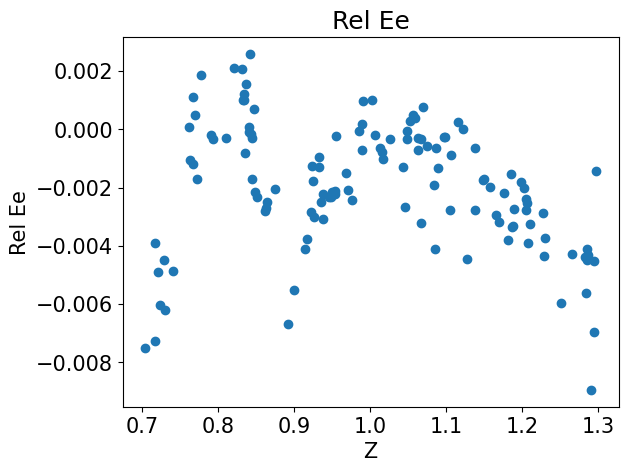

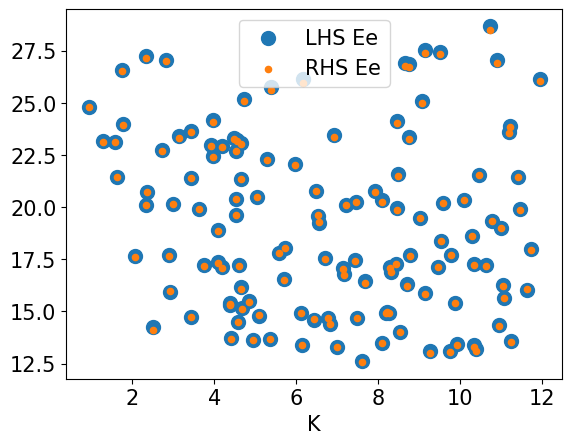

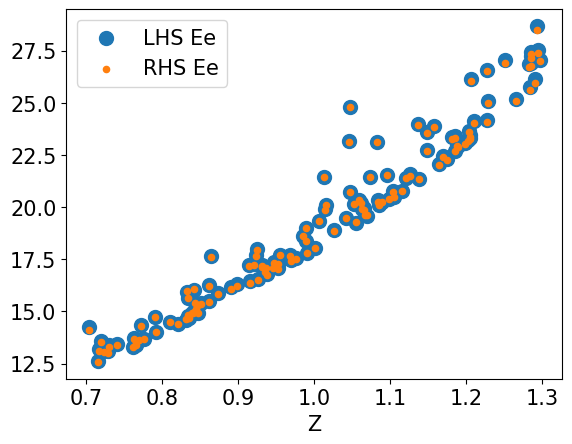

#=================================================================
episode = 5000, loss [log10] = -5.34459136678221
#=================================================================
episode = 6000, loss [log10] = -5.391457448119168
#=================================================================
episode = 7000, loss [log10] = -5.470670487779342
#=================================================================
episode = 8000, loss [log10] = -5.496045853735747


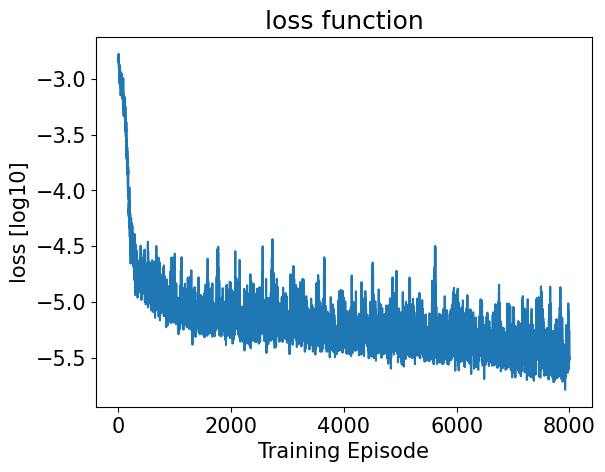

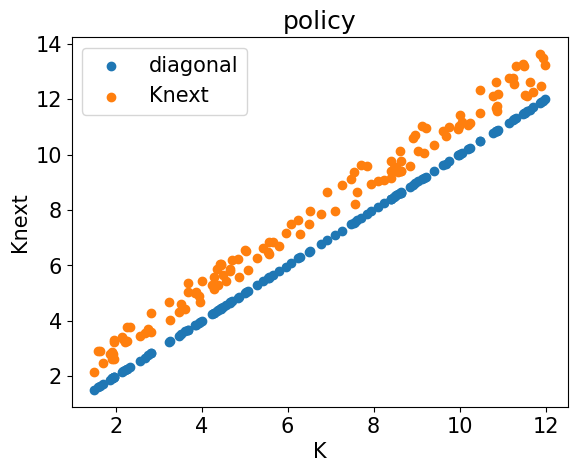

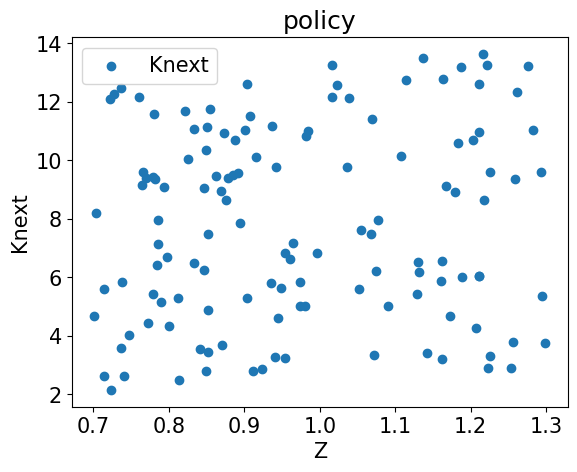

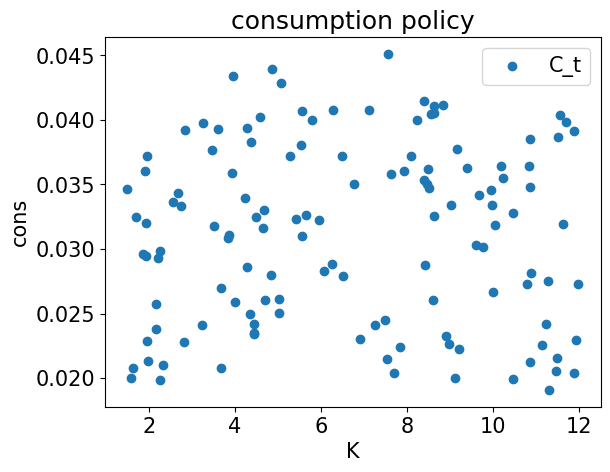

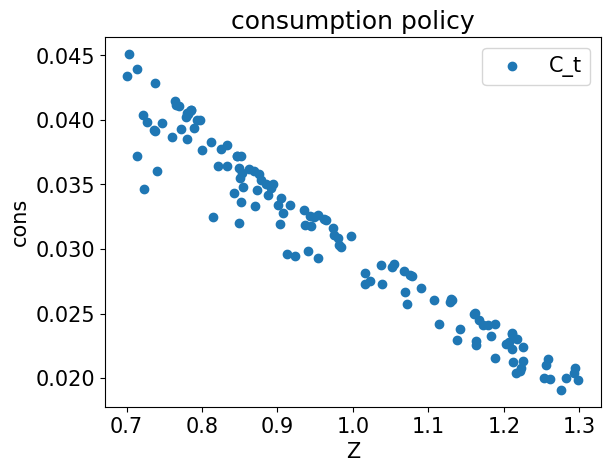

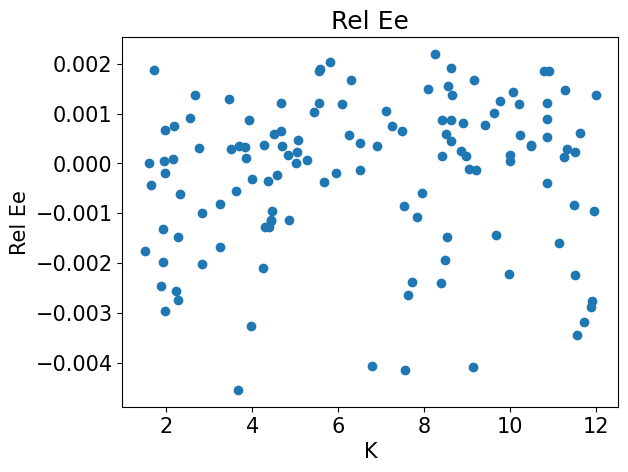

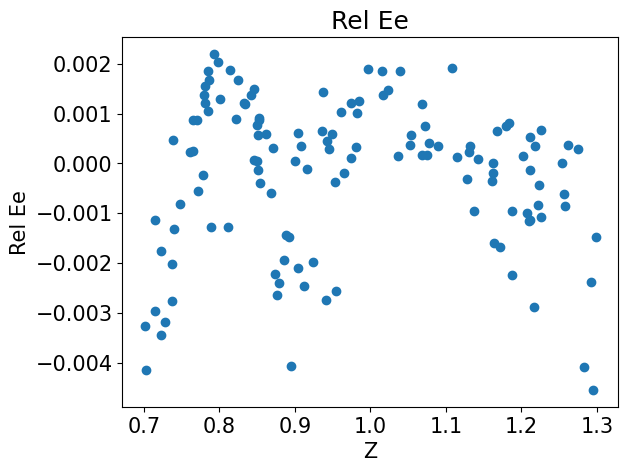

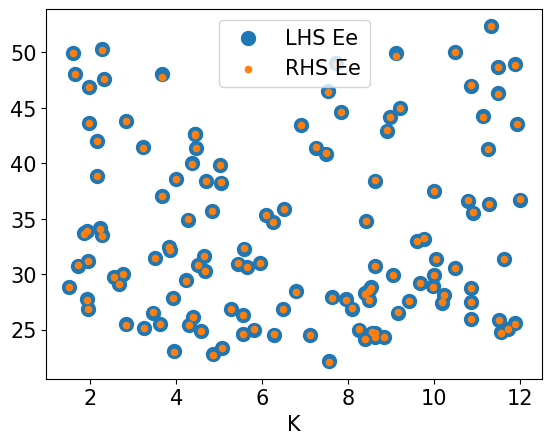

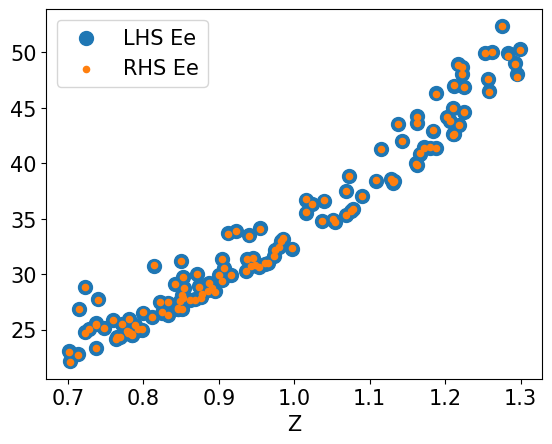

#=================================================================
episode = 9000, loss [log10] = -5.706573246523629
#=================================================================
episode = 10000, loss [log10] = -5.677046819749846
#=================================================================
episode = 11000, loss [log10] = -5.362744957487848
#=================================================================
episode = 12000, loss [log10] = -5.792016730911396


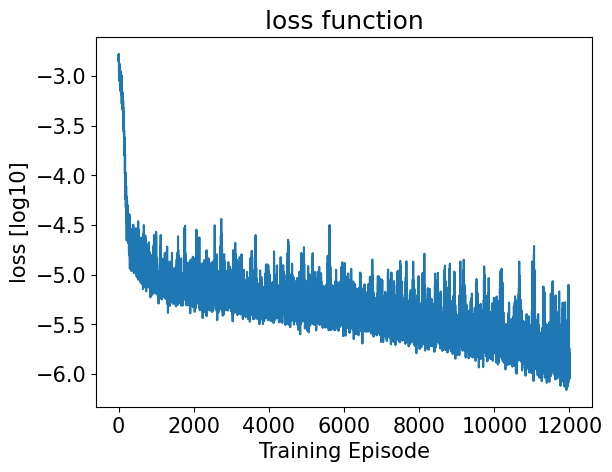

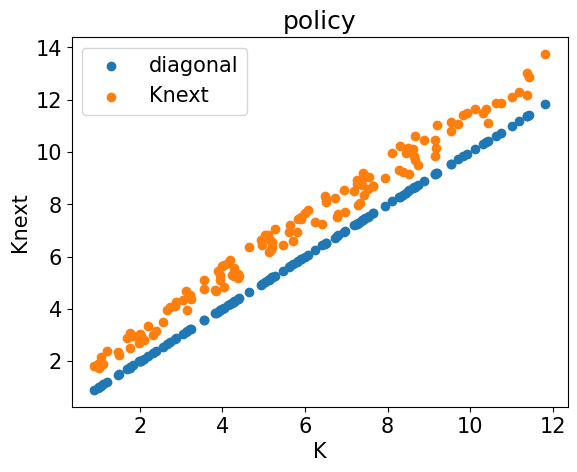

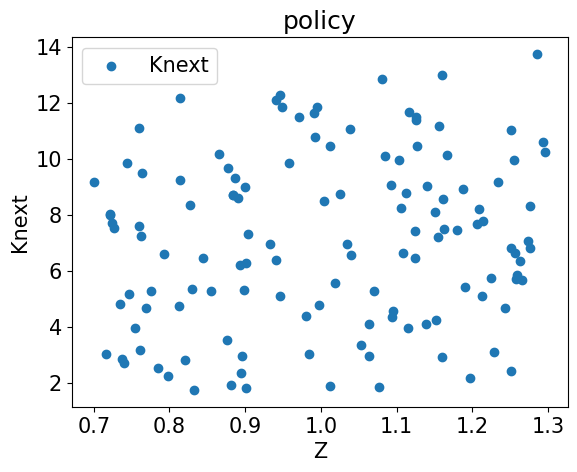

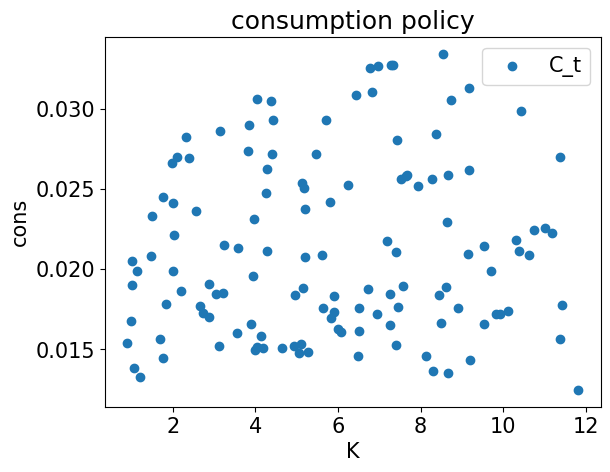

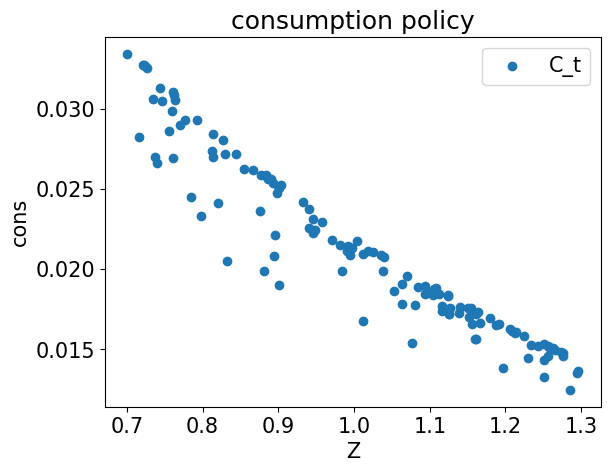

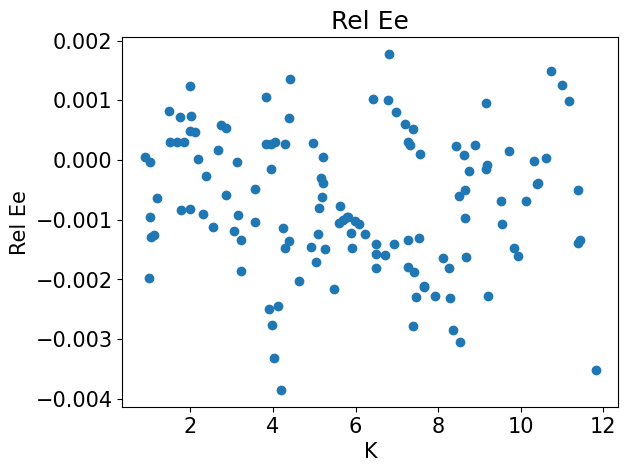

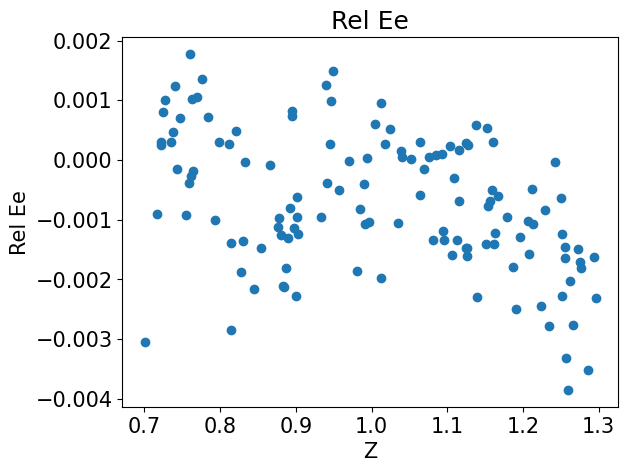

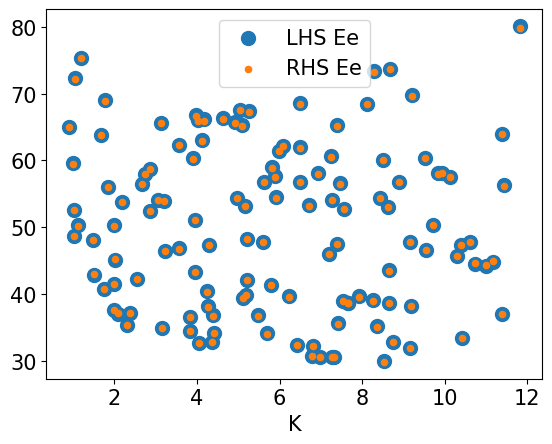

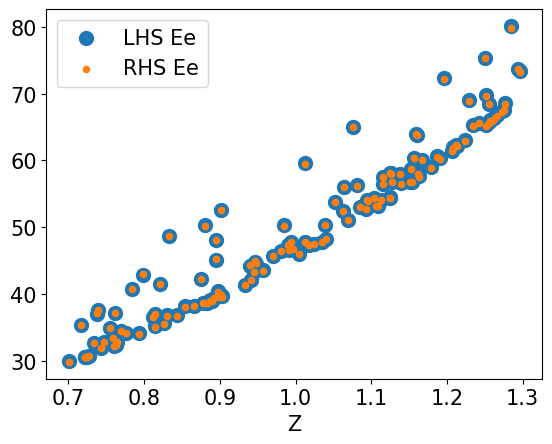

#=================================================================
episode = 13000, loss [log10] = -6.131189416491176
#=================================================================
episode = 14000, loss [log10] = -5.365892409049899
#=================================================================
episode = 15000, loss [log10] = -6.208764885931324
#=================================================================
episode = 16000, loss [log10] = -6.067888014290151


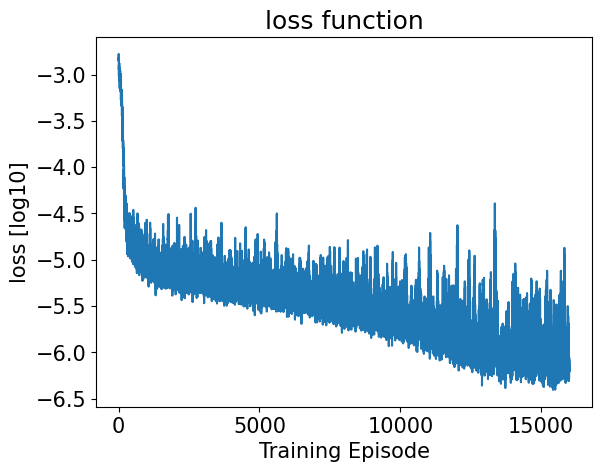

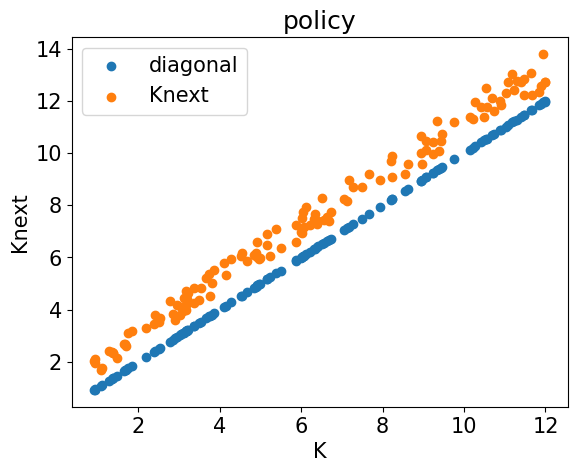

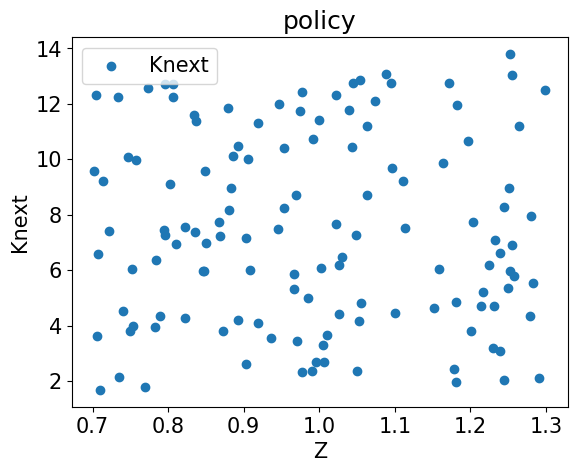

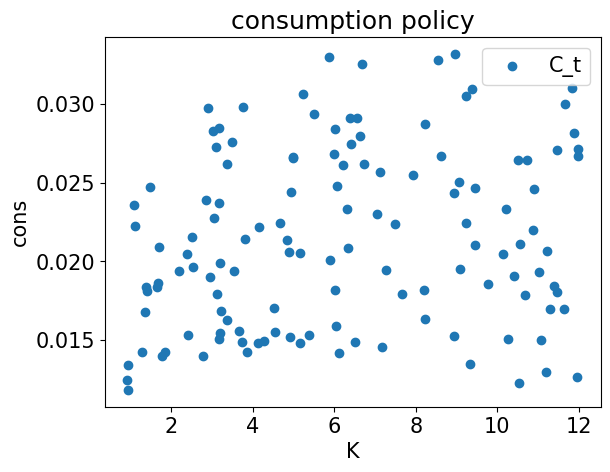

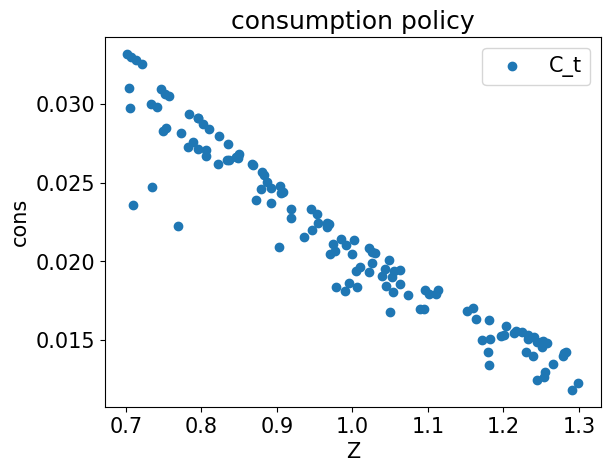

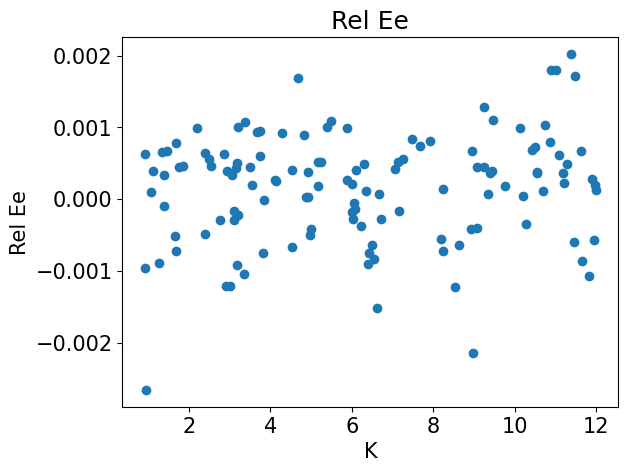

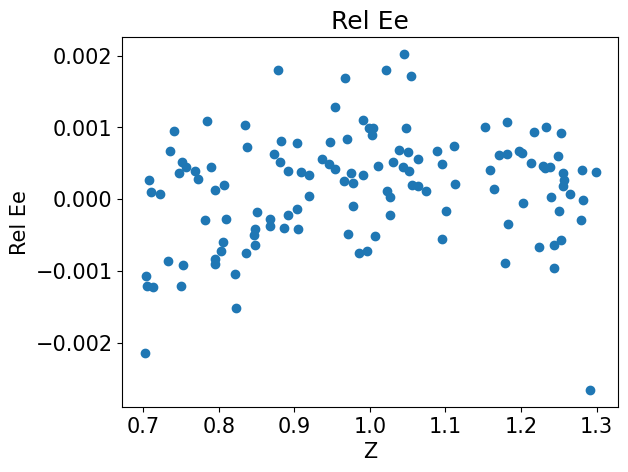

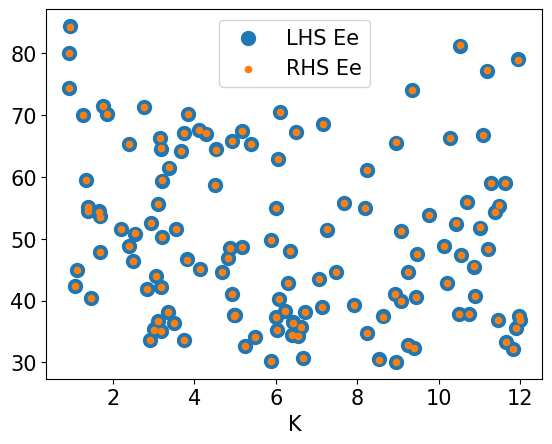

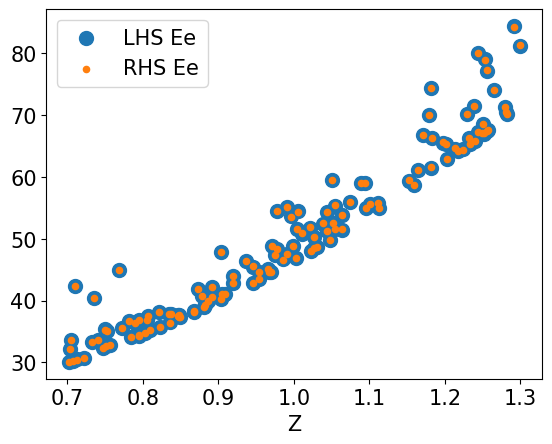

#=================================================================
episode = 17000, loss [log10] = -5.878172101216121
#=================================================================
episode = 18000, loss [log10] = -5.994112252534756
#=================================================================
episode = 19000, loss [log10] = -6.2574431947531695
#=================================================================
episode = 20000, loss [log10] = -6.485188574148295


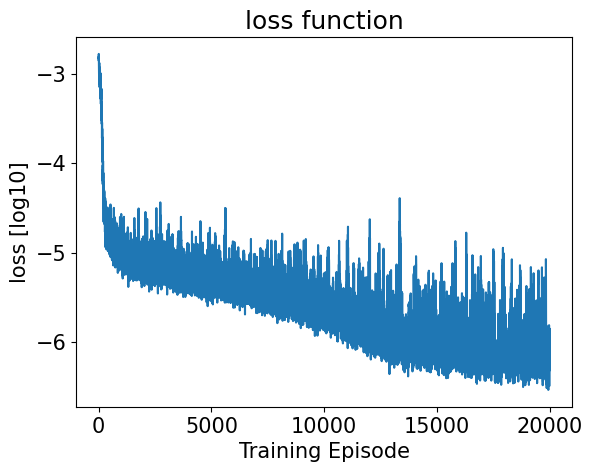

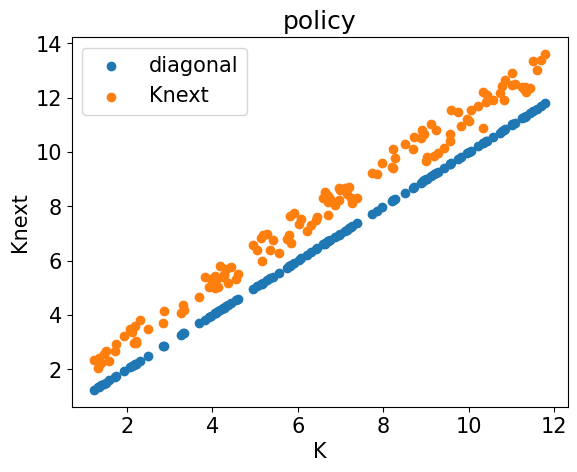

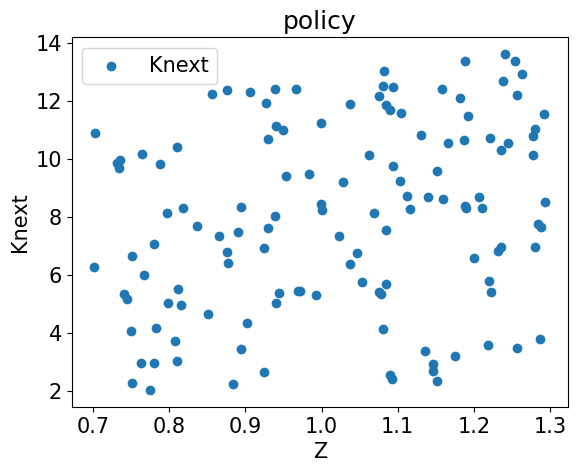

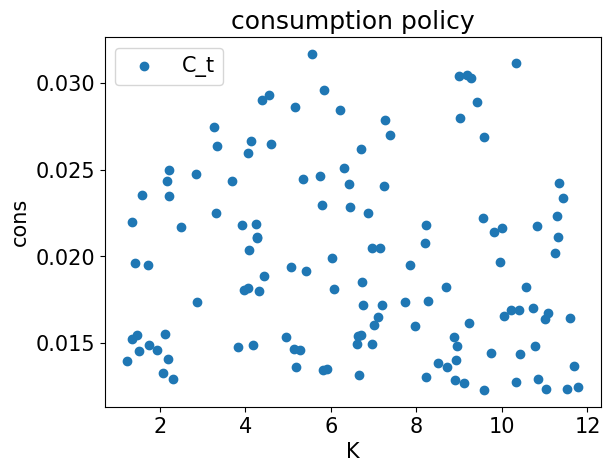

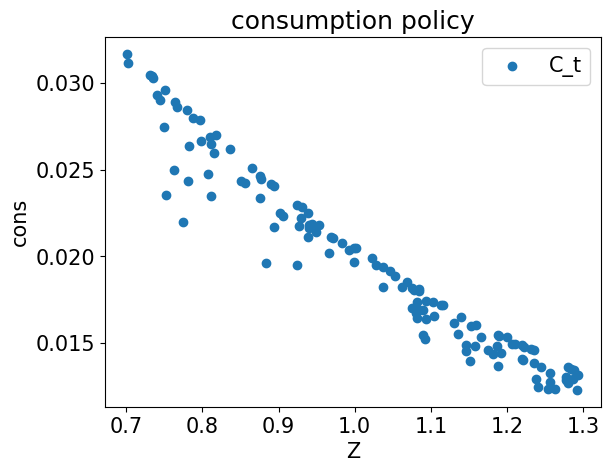

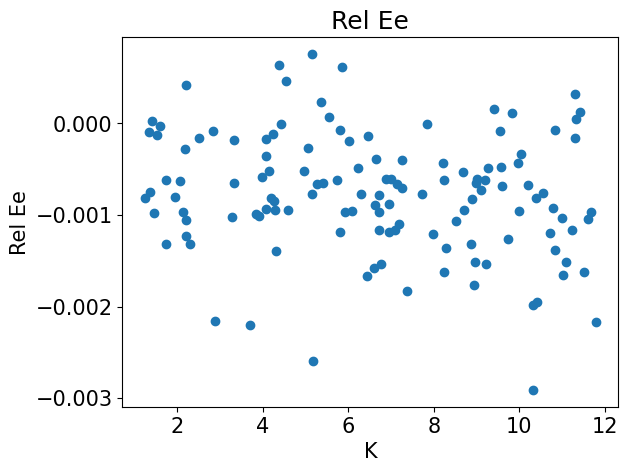

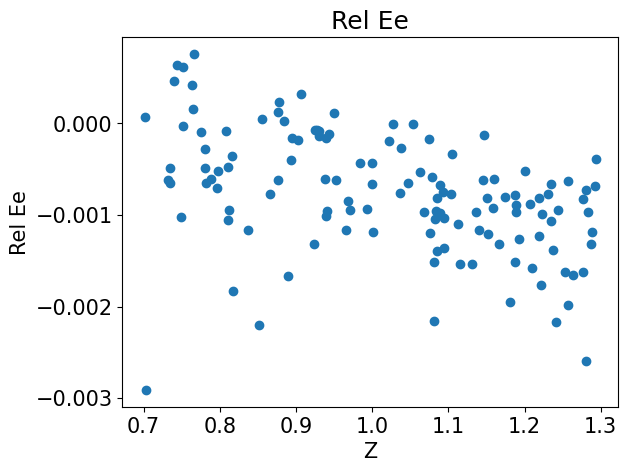

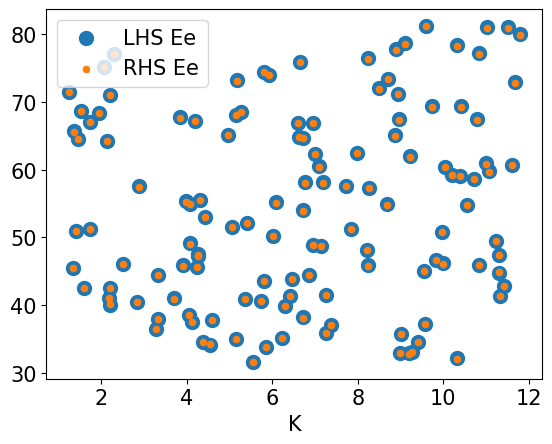

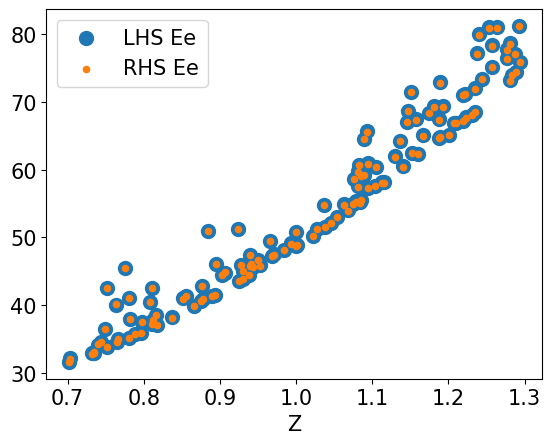

In [27]:
train_loss = []

num_episodes = 20001
n_data_per_epi = 128
z_lb = 0.7
z_ub = 1.3
k_lb = 0.9
k_ub = 12.0


for ep in range(num_episodes):
    # generate training data
    X = get_training_data(z_lb, z_ub, k_lb, k_ub, n_data_per_epi)

    loss = compute_cost(X, model)


    optimizer.zero_grad()  # 清除梯度
    loss.backward()  # 计算梯度
    optimizer.step()  # 更新参数


    # record loss
    train_loss.append(loss.item())

    # print progress
    if ep % int(0.05 * num_episodes) == 0:
        print("#=================================================================")
        print("episode = {}, loss [log10] = {}".format(ep, np.log10(loss.item())))

    if ep % int(0.2 * num_episodes) == 0 or ep == num_episodes - 1:
        cost, errREE, C_t, K_tplus1, r_t, LHS, RHS = compute_cost_tuple(X, model)
        cost = cost.detach().numpy()
        errREE = errREE.detach().numpy()
        C_t = C_t.detach().numpy()
        K_tplus1 = K_tplus1.detach().numpy()
        r_t = r_t.detach().numpy()
        LHS = LHS.detach().numpy()
        RHS = RHS.detach().numpy()

        plt.title("loss function")
        plt.plot(np.log10(np.array(train_loss)))
        plt.xlabel("Training Episode")
        plt.ylabel("loss [log10]")
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("K")
        plt.ylabel("Knext")
        plt.scatter(X[:, 1], X[:, 1], label = "diagonal")
        plt.scatter(X[:, 1], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("policy")
        plt.xlabel("Z")
        plt.ylabel("Knext")
        plt.scatter(X[:, 0], K_tplus1[:, 0], label = "Knext")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("K")
        plt.ylabel("cons")
        plt.scatter(X[:, 1], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("consumption policy")
        plt.xlabel("Z")
        plt.ylabel("cons")
        plt.scatter(X[:, 0], C_t[:, 0], label="C_t")
        plt.legend()
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("K")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 1], errREE[:, 0], label="REE")
        plt.show()
        plt.close()

        plt.title("Rel Ee")
        plt.xlabel("Z")
        plt.ylabel("Rel Ee")
        plt.scatter(X[:, 0], errREE[:, 0], label="REE")
        plt.show()
        plt.close()

        plt.xlabel("K")
        plt.scatter(X[:, 1], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 1], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()

        plt.xlabel("Z")
        plt.scatter(X[:, 0], LHS[:, 0], s = 100, label="LHS Ee")
        plt.scatter(X[:, 0], RHS[:, 0], s = 20, label="RHS Ee")
        plt.legend()
        plt.show()
        plt.close()
